<a href="https://colab.research.google.com/github/Jagoda222/LoLa---group-8/blob/main/calculate_measure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [18]:
!pip install -U datasets
!pip install evaluate
!pip install spacy
!python -m spacy download en_core_web_md
!pip install syllapy
!pip install accelerate -U

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [19]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import datasets
import pandas as pd
import os
from sentence_transformers import SentenceTransformer, util
import spacy
from evaluate import load
import torch
import nltk
import syllapy
from collections import Counter

nlp = spacy.load("en_core_web_md")
nltk.download('punkt_tab')


ImportError: cannot import name 'load_metric' from 'datasets' (/usr/local/lib/python3.11/dist-packages/datasets/__init__.py)

#1. Models comparison

##GPT2

In [ ]:
MODEL_DIR = 'model_checkpoints'
MODEL_CHECKPOINT = "openai-community/gpt2-large"
BATCH_SIZE = 16
snli_data = load_dataset("snli")
print(Counter(snli_data['train']['label']))
for k in snli_data:
    snli_data[k] = snli_data[k].filter( lambda prob: prob['label'] >= 0 )

metric = load('glue', "mnli")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

# a padding token for GPT-2 since it doesn’t have one by default
tokenizer.pad_token = tokenizer.eos_token
def preprocess_function(d):
    return tokenizer(d['premise'], d['hypothesis'], truncation=True)
encoded_snli_data = snli_data.map(preprocess_function, batched=True, load_from_cache_file=True)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=3)
model.config.pad_token_id = model.config.eos_token_id

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

args = TrainingArguments(
    MODEL_DIR, # to save models
    # evaluation_strategy = "epoch", # 1 epoch for training takes too long for colab
    evaluation_strategy = "steps",
    eval_steps = 500, # evaluate and save after training on every next 500x16 examples
    save_steps=500, # saves model after every 500 steps. save_steps should be divisible on eval_steps
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=1, # going throught the training data only once
    weight_decay=0.01,
    load_best_model_at_end=True, # after fine-tuning trainer.model will keep the best model
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_snli_data["train"].select(range(2000)),
    eval_dataset=encoded_snli_data["validation"],
    # You could use "test" here but it will be cheating then
    # to select the model checkpoint which gets highest score on test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()


# evaluation of a particular model

# if you want to load a model from a checkpoint for evaluation
# ft_model = AutoModelForSequenceClassification.from_pretrained(op.join(MODEL_DIR, 'checkpoint-5000'))

trainer_eval = Trainer(
    trainer.model, # model that you want to evaluate, In this case this is the best model based on the fine-tuning
    args,
    train_dataset=encoded_snli_data["train"].select(range(2000)),
    eval_dataset=encoded_snli_data["validation"], # you want to evaluate on test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer_eval.evaluate()

## DeBERTA

In [ ]:

# META Variables
# it is good to have certain directories for saving model checkpoints (e.g., on google drive)
MODEL_DIR = 'model_checkpoints'
DB_MODEL_CHECKPOINT = "microsoft/deberta-base"
BATCH_SIZE = 16


snli_data = load_dataset("snli")
print(Counter(snli_data['train']['label']))

# SNLI data needs to be cleaned as it contains -1s as a label
for k in snli_data:
    snli_data[k] = snli_data[k].filter( lambda prob: prob['label'] >= 0 )


metric = load('glue', "mnli")
tokenizer = AutoTokenizer.from_pretrained(DB_MODEL_CHECKPOINT)
def preprocess_function(d):
    return tokenizer(d['premise'], d['hypothesis'], truncation=True)
encoded_snli_data = snli_data.map(preprocess_function, batched=True, load_from_cache_file=True)
model = AutoModelForSequenceClassification.from_pretrained(DB_MODEL_CHECKPOINT, num_labels=3)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

args = TrainingArguments(
    MODEL_DIR, # to save models
    # evaluation_strategy = "epoch", # 1 epoch for training takes too long for colab
    evaluation_strategy = "steps",
    eval_steps = 500, # evaluate and save after training on every next 500x16 examples
    save_steps=500, # saves model after every 500 steps. save_steps should be divisible on eval_steps
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=1, # going throught the training data only once
    weight_decay=0.01,
    load_best_model_at_end=True, # after fine-tuning trainer.model will keep the best model
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_snli_data["train"].select(range(2000)),
    eval_dataset=encoded_snli_data["validation"],
    # You could use "test" here but it will be cheating then
    # to select the model checkpoint which gets highest score on test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

# evaluation of a particular model

# if you want to load a model from a checkpoint for evaluation
# ft_model = AutoModelForSequenceClassification.from_pretrained(op.join(MODEL_DIR, 'checkpoint-5000'))

trainer_eval = Trainer(
    trainer.model, # model that you want to evaluate, In this case this is the best model based on the fine-tuning
    args,
    train_dataset=encoded_snli_data["train"].select(range(2000)),
    eval_dataset=encoded_snli_data["validation"], # you want to evaluate on test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer_eval.evaluate()


## RoBERTA

In [ ]:
# it is good to have certain directories for saving model checkpoints (e.g., on google drive)
MODEL_DIR = 'model_checkpoints'
DB_MODEL_CHECKPOINT = "roberta-base"
BATCH_SIZE = 16


snli_data = load_dataset("snli")
print(Counter(snli_data['train']['label']))

# SNLI data needs to be cleaned as it contains -1s as a label
for k in snli_data:
    snli_data[k] = snli_data[k].filter( lambda prob: prob['label'] >= 0 )


metric = load('glue', "mnli")
tokenizer = AutoTokenizer.from_pretrained(DB_MODEL_CHECKPOINT)
def preprocess_function(d):
    return tokenizer(d['premise'], d['hypothesis'], truncation=True)
encoded_snli_data = snli_data.map(preprocess_function, batched=True, load_from_cache_file=True)
model = AutoModelForSequenceClassification.from_pretrained(DB_MODEL_CHECKPOINT, num_labels=3)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

args = TrainingArguments(
    MODEL_DIR, # to save models
    # evaluation_strategy = "epoch", # 1 epoch for training takes too long for colab
    evaluation_strategy = "steps",
    eval_steps = 500, # evaluate and save after training on every next 500x16 examples
    save_steps=500, # saves model after every 500 steps. save_steps should be divisible on eval_steps
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=1, # going throught the training data only once
    weight_decay=0.01,
    load_best_model_at_end=True, # after fine-tuning trainer.model will keep the best model
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_snli_data["train"].select(range(2000)),
    eval_dataset=encoded_snli_data["validation"],
    # You could use "test" here but it will be cheating then
    # to select the model checkpoint which gets highest score on test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

# evaluation of a particular model

# if you want to load a model from a checkpoint for evaluation
# ft_model = AutoModelForSequenceClassification.from_pretrained(op.join(MODEL_DIR, 'checkpoint-5000'))

trainer_eval = Trainer(
    trainer.model, # model that you want to evaluate, In this case this is the best model based on the fine-tuning
    args,
    train_dataset=encoded_snli_data["train"].select(range(2000)),
    eval_dataset=encoded_snli_data["validation"], # you want to evaluate on test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer_eval.evaluate()


## DeBERTA V3 small

In [ ]:
# it is good to have certain directories for saving model checkpoints (e.g., on google drive)
MODEL_DIR = 'model_checkpoints'
DB_MODEL_CHECKPOINT = "microsoft/deberta-v3-small"
BATCH_SIZE = 16


snli_data = load_dataset("snli")
print(Counter(snli_data['train']['label']))

# SNLI data needs to be cleaned as it contains -1s as a label
for k in snli_data:
    snli_data[k] = snli_data[k].filter( lambda prob: prob['label'] >= 0 )


metric = load('glue', "mnli")
tokenizer = AutoTokenizer.from_pretrained(DB_MODEL_CHECKPOINT)
def preprocess_function(d):
    return tokenizer(d['premise'], d['hypothesis'], truncation=True)
encoded_snli_data = snli_data.map(preprocess_function, batched=True, load_from_cache_file=True)
model = AutoModelForSequenceClassification.from_pretrained(DB_MODEL_CHECKPOINT, num_labels=3)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

args = TrainingArguments(
    MODEL_DIR, # to save models
    # evaluation_strategy = "epoch", # 1 epoch for training takes too long for colab
    evaluation_strategy = "steps",
    eval_steps = 500, # evaluate and save after training on every next 500x16 examples
    save_steps=500, # saves model after every 500 steps. save_steps should be divisible on eval_steps
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=1, # going throught the training data only once
    weight_decay=0.01,
    load_best_model_at_end=True, # after fine-tuning trainer.model will keep the best model
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_snli_data["train"].select(range(2000)),
    eval_dataset=encoded_snli_data["validation"],
    # You could use "test" here but it will be cheating then
    # to select the model checkpoint which gets highest score on test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

# evaluation of a particular model

# if you want to load a model from a checkpoint for evaluation
# ft_model = AutoModelForSequenceClassification.from_pretrained(op.join(MODEL_DIR, 'checkpoint-5000'))

trainer_eval = Trainer(
    trainer.model, # model that you want to evaluate, In this case this is the best model based on the fine-tuning
    args,
    train_dataset=encoded_snli_data["train"].select(range(2000)),
    eval_dataset=encoded_snli_data["validation"], # you want to evaluate on test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer_eval.evaluate()


#2. Hyperparameter tuning on DeBERTA V3 small:

- Best Trial:
- Value: 0.818837634271083
- Params:
  - learning_rate: 5.107619333997887
  - weight_decay: 0.0074907628074252
  - warmup_steps: 211


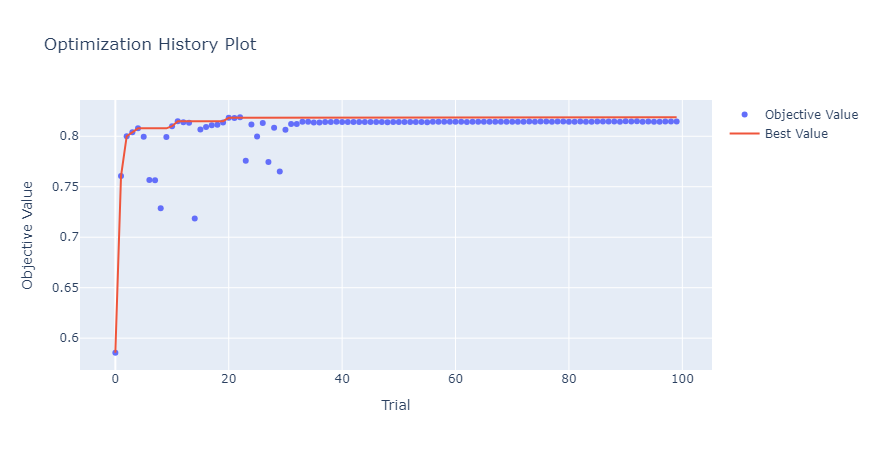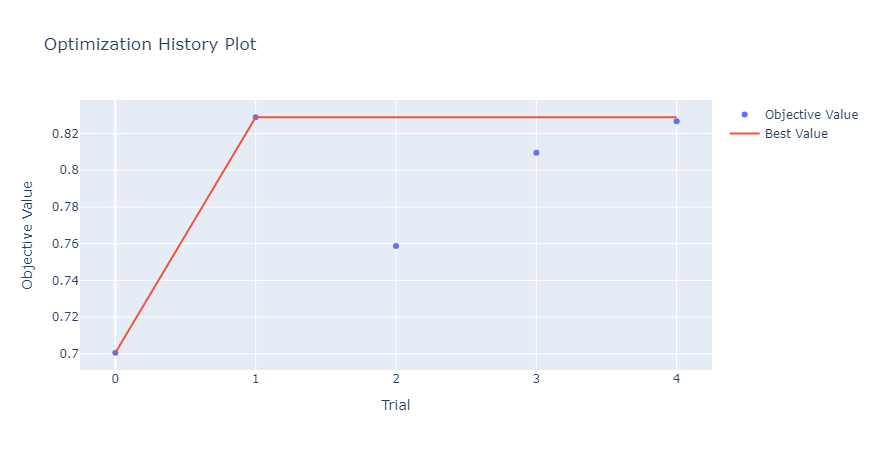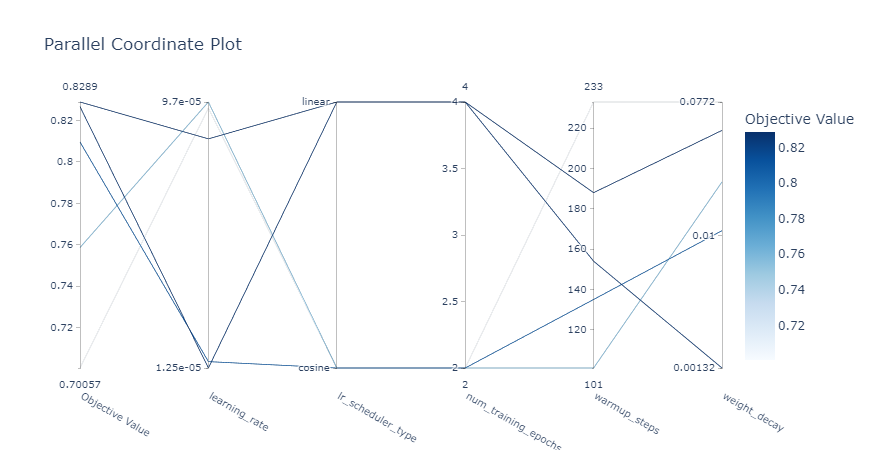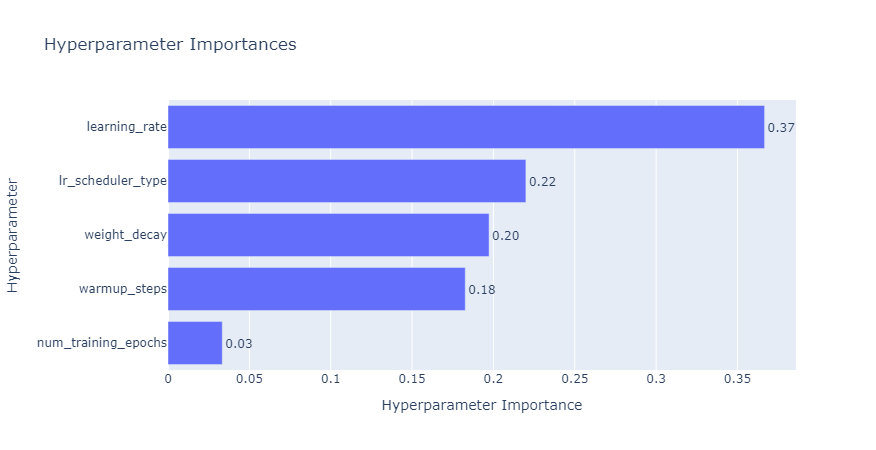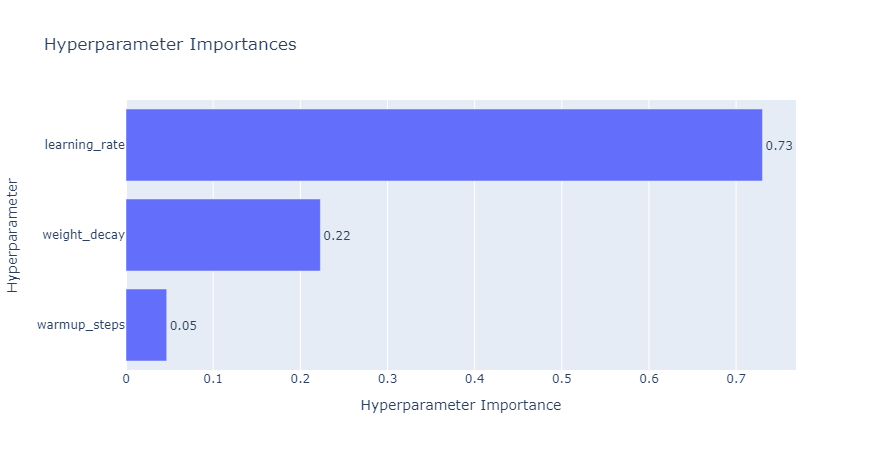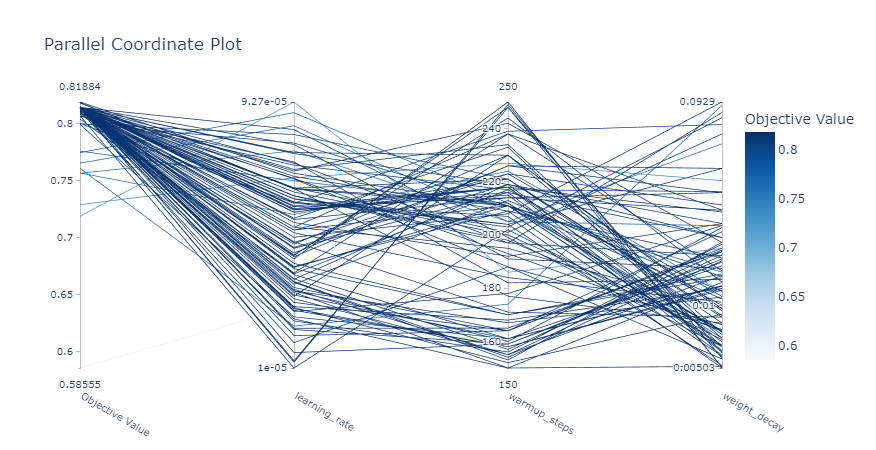

# Extracting the 10k random triples from snli



In [ ]:
dataset = load_dataset("snli")
train_data = dataset['train'].to_pandas()
train_data = train_data[train_data['label'].notnull()]

#Assigning number to each triplet
triplet_nr = 1
triplet_numbers = []

for i in range(0, len(train_data), 3):
    group = train_data.iloc[i:i+3]
    if len(group['premise'].unique()) == 1 and len(group) == 3:
        triplet_numbers.extend([triplet_nr] * 3)
        triplet_nr += 1
    else:
        triplet_numbers.extend([None] * len(group))

train_data['triplet_nr'] = triplet_numbers
train_data = train_data.dropna(subset=['triplet_nr'])
train_data['triplet_nr'] = train_data['triplet_nr'].astype(int)


#Delete triplets with -1 label
triplets_with_neg1 = train_data[ train_data['label'] == -1]['triplet_nr'].unique()
train_data = train_data[~train_data['triplet_nr'].isin(triplets_with_neg1)]

#Checking if removing -1 label triples was succesful
print("Unique labels in train_data:", train_data['label'].unique())
triplets_with_neg1 = train_data[train_data['label'] == -1]['triplet_nr'].unique()
print(f"Total number of triplets containing label -1: {len(triplets_with_neg1)}")
triplets_with_neg1_data = train_data[train_data['triplet_nr'].isin(triplets_with_neg1)]

print("First 3 triplets containing at least one row with label -1:")
for triplet_nr in triplets_with_neg1[:3]:
    print(f"\nTriplet Number: {triplet_nr}")
    print(triplets_with_neg1_data[triplets_with_neg1_data['triplet_nr'] == triplet_nr])



##Dividing dataset in 10 blocks. Choosing 1000 random triplets from each block.

In [ ]:
num_blocks = 10
triplets_per_block = 1000

unique_triplets = train_data['triplet_nr'].unique()
triplets_without_neg1 = np.setdiff1d(unique_triplets, triplets_with_neg1)
num_triplets = len(unique_triplets)
block_size = num_triplets // num_blocks

sampled_triplets = []

for i in range(num_blocks):
    start_idx = i * block_size
    end_idx = (i + 1) * block_size if i < num_blocks - 1 else num_triplets
    block_triplets = unique_triplets[start_idx:end_idx]
    block_triplets_without_neg1 = np.intersect1d(block_triplets, triplets_without_neg1)
    sampled_without_neg1 = train_data[train_data['triplet_nr'].isin(block_triplets_without_neg1)]
    sampled_without_neg1 = sampled_without_neg1['triplet_nr'].drop_duplicates().sample(
        n=min(triplets_per_block, len(block_triplets_without_neg1)), random_state=42
    )
    sampled_without_neg1 = train_data[train_data['triplet_nr'].isin(sampled_without_neg1)]
    sampled_triplets.append(sampled_without_neg1)

sampled_triplets_combined = pd.concat(sampled_triplets)

print(f"Total number of unique triplets chosen: {sampled_triplets_combined['triplet_nr'].nunique()}")
print("\nLabel distribution in the sampled data:")
print(sampled_triplets_combined['label'].value_counts())
sampled_triplets_combined.to_csv('sampled_snli_10000.csv', index=False)

# Measure calculation and sampling the data (700 triplets)

## Function for sampling based on the measure

In [8]:
def process_snli_dataset_with_measures(file_path, sample_size=700, num_bins=7, measures=None):
    """
    Process an SNLI dataset for curriculum learning with one measure at a time, proportional sampling, and random baseline.

    Args:
        file_path (str): Path to the CSV file containing the dataset.
        sample_size (int): The number of triplets to sample from the dataset. Default is 700.
        num_bins (int): Number of bins for dividing measure values. Default is 7.
        measures (list): List of functions to calculate complexity measures.

    Returns:
        dict: Dictionary containing increasing, decreasing, and random baseline DataFrames for each measure.
    """
    data = pd.read_csv(file_path)
    data['premise'] = data['premise'].fillna("").astype(str)
    data['hypothesis'] = data['hypothesis'].fillna("").astype(str)
    result = {}

    for idx, measure_func in enumerate(measures):
        measure_name = measure_func.__name__
        data[measure_name] = data.apply(measure_func, axis=1)
        triplet_avg = data.groupby('triplet_nr')[measure_name].mean().reset_index(name='triplet_avg')
        bin_edges = np.linspace(triplet_avg['triplet_avg'].min(), triplet_avg['triplet_avg'].max(), num_bins + 1)
        triplet_avg['range_bin'] = pd.cut(triplet_avg['triplet_avg'], bins=bin_edges, labels=False, include_lowest=True)
        bin_distribution = triplet_avg['range_bin'].value_counts().sort_index()
        print(f"\nDistribution of triplets across bins for {measure_name}:\n{bin_distribution}")
        triplets_per_bin = (bin_distribution / bin_distribution.sum() * sample_size).astype(int)

        while triplets_per_bin.sum() < sample_size:
            residuals = (bin_distribution / bin_distribution.sum() * sample_size) - triplets_per_bin
            triplets_per_bin[residuals.idxmax()] += 1

        while triplets_per_bin.sum() > sample_size:
            residuals = (bin_distribution / bin_distribution.sum() * sample_size) - triplets_per_bin
            triplets_per_bin[residuals.idxmin()] -= 1

        sampled_triplets = []
        for bin_id, sample_count in triplets_per_bin.items():
            if sample_count > 0:
                triplets_in_bin = triplet_avg[triplet_avg['range_bin'] == bin_id]['triplet_nr'].values
                sampled_triplet_ids = np.random.choice(triplets_in_bin, size=min(sample_count, len(triplets_in_bin)), replace=False)
                sampled_triplets.append(data[data['triplet_nr'].isin(sampled_triplet_ids)])

        final_sample = pd.concat(sampled_triplets).reset_index(drop=True)
        final_sample = final_sample.merge(triplet_avg[['triplet_nr', 'triplet_avg']], on='triplet_nr')

        final_sample_increasing = final_sample.sort_values(by='triplet_avg').reset_index(drop=True)
        final_sample_decreasing = final_sample.sort_values(by='triplet_avg', ascending=False).reset_index(drop=True)
        baseline = final_sample.sample(frac=1, random_state=100)

        result[measure_name] = {
            'increasing': final_sample_increasing,
            'decreasing': final_sample_decreasing,
            'baseline': baseline
        }

    print(f"Processed {sample_size} triplets and returned ordered DataFrames for each measure.")
    return result


## Syntactic Overlap + Lexical Diversity + Sentence Length (SO + LD + SL)

In [4]:
def so_ld_sl(row):
    """Calculate combined complexity score using syntactic overlap, lexical diversity, and sentence length."""

    premise = row['premise']
    hypothesis = row['hypothesis']

    def longest_common_subsequence(X, Y):
        """Calculate the length of the longest common subsequence between two sentences."""
        m, n = len(X), len(Y)
        dp = [[0] * (n + 1) for _ in range(m + 1)]

        for i in range(1, m + 1):
            for j in range(1, n + 1):
                if X[i - 1] == Y[j - 1]:
                    dp[i][j] = dp[i - 1][j - 1] + 1
                else:
                    dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])
        return dp[m][n]

    def syntactic_overlap(premise, hypothesis):
        """Calculate syntactic overlap using longest common subsequence."""
        premise_words = premise.split()
        hypothesis_words = hypothesis.split()
        lcs_length = longest_common_subsequence(premise_words, hypothesis_words)
        return lcs_length / max(len(premise_words), len(hypothesis_words))

    def lexical_diversity_comparison(premise, hypothesis):
        """Calculate lexical diversity comparison between premise and hypothesis."""
        premise_words = set(premise.split())
        hypothesis_words = set(hypothesis.split())
        shared_unique_words = len(premise_words & hypothesis_words)
        total_words = len(premise.split()) + len(hypothesis.split())
        return shared_unique_words / total_words if total_words > 0 else 0

    syntactic_diff = 1 - syntactic_overlap(premise, hypothesis)

    lexical_diversity_score = 1 - lexical_diversity_comparison(premise, hypothesis)

    max_length = 78  # Maximum sentence length for normalization
    combined_length = len(premise.split()) + len(hypothesis.split())
    normalized_length = combined_length / max_length

    w1, w2, w3 = 0.5, 0.3, 0.2  # Weights for syntactic overlap, lexical diversity, and length
    complexity_score = (w1 * syntactic_diff) + (w2 * lexical_diversity_score) + (w3 * normalized_length)

    return complexity_score

### Syntactic Tree Depth Measure

In [5]:
def tree_depth(text):

    def get_dependency_depth(token):
        """Recursively find the depth of a token in the dependency tree."""
        if token == token.head:  # Root node (self-referential head)
            return 0
        return 1 + get_dependency_depth(token.head)

    doc = nlp(text)

    return max(get_dependency_depth(token) for token in doc) if len(doc) > 0 else 0

def tree_depth_premise(row):
    """
    Compute the tree depth for the premise of a single row.
    """
    return tree_depth(row["premise"])

def tree_depth_hypothesis(row):
    """
    Compute the tree depth for the hypothesis of a single row.
    """
    return tree_depth(row["hypothesis"])

### Sentence Length Measure

In [6]:
def length_calc(text):
    """
    Function to calculate the number of words in a given text.
    """
    return len(text.split())

def sentence_length_premise(row):
    """
    Compute the sentence length for the premise of a single row.
    """
    return length_calc(row["premise"])

def sentence_length_hypothesis(row):
    """
    Compute the sentence length for the hypothesis of a single row.
    """
    return length_calc(row["hypothesis"])

def sentence_length_combined(row):
    """
    Compute the combined length of the premise and hypothesis for a single row.
    """
    return sentence_length_premise(row) + sentence_length_hypothesis(row)


### Flesch-Kincaid Measure

In [7]:
def flesch_kincaid_calc(text):
    """
    function to compute the Flesch-Kincaid Grade Level for a given text.
    """
    sentences = nltk.sent_tokenize(text)
    words = nltk.word_tokenize(text)


    total_words = max(len(words), 1)
    total_sentences = max(len(sentences), 1)
    total_syllables = sum(syllapy.count(word) for word in words)

    # Flesch-Kincaid Grade Level formula
    grade_level = 0.39 * (total_words / total_sentences) + 11.8 * (total_syllables / total_words) - 15.59
    return round(grade_level, 2)

def flesch_kincaid_premise(row):
    """
    Compute the Flesch-Kincaid Grade Level for the premise of a single row.
    """
    return flesch_kincaid_calc(row["premise"])

def flesch_kincaid_hypothesis(row):
    """
    Compute the Flesch-Kincaid Grade Level for the hypothesis of a single row.
    """
    return flesch_kincaid_calc(row["hypothesis"])

def flesch_kincaid_combined(row):
    """
    Compute the combined Flesch-Kincaid Grade Level (premise + hypothesis) for a single row.
    """
    return flesch_kincaid_premise(row) + flesch_kincaid_hypothesis(row)

In [11]:
file_path = "/content/sampled_snli_10000.csv"
measure_list = [so_ld_sl, tree_depth_premise, tree_depth_hypothesis, sentence_length_premise,
                sentence_length_hypothesis, sentence_length_combined, flesch_kincaid_premise,
                flesch_kincaid_hypothesis, flesch_kincaid_combined
                ]
result = process_snli_dataset_with_measures(file_path, sample_size=700, num_bins=7, measures=measure_list)

# Step to save increasing, decreasing, and random baseline DataFrames for each measure
for measure_name, dataframes in result.items():
    # Extract increasing, decreasing, and random baseline DataFrames
    increasing_df = dataframes['increasing']
    decreasing_df = dataframes['decreasing']
    random_baseline_df = dataframes['baseline']

    # Save to CSV
    increasing_df.to_csv(f"/content/{measure_name}_increasing.csv", index=False)
    decreasing_df.to_csv(f"/content/{measure_name}_decreasing.csv", index=False)
    random_baseline_df.to_csv(f"/content/{measure_name}_baseline.csv", index=False)

    print(f"Saved {measure_name} DataFrames to CSV:")
    print(f"/content/{measure_name}_increasing.csv")
    print(f"/content/{measure_name}_decreasing.csv")
    print(f"/content/{measure_name}_baseline.csv")



Distribution of triplets across bins for so_ld_sl:
range_bin
0     135
1     138
2     699
3    2468
4    4641
5    1910
6       9
Name: count, dtype: int64

Distribution of triplets across bins for tree_depth_premise:
range_bin
0    2595
1    6179
2     945
3     252
4      23
5       5
6       1
Name: count, dtype: int64

Distribution of triplets across bins for tree_depth_hypothesis:
range_bin
0    1392
1    6329
2    1983
3     252
4      38
5       3
6       3
Name: count, dtype: int64

Distribution of triplets across bins for sentence_length_premise:
range_bin
0    5705
1    3862
2     385
3      43
4       2
5       1
6       2
Name: count, dtype: int64

Distribution of triplets across bins for sentence_length_hypothesis:
range_bin
0    1856
1    6345
2    1553
3     214
4      25
5       5
6       2
Name: count, dtype: int64

Distribution of triplets across bins for sentence_length_combined:
range_bin
0    3268
1    5651
2     977
3      89
4      12
5       2
6       1
Name: 

#Running models on the sampled data

In [17]:
MODEL_DIR = 'model_checkpoints'
MODEL_CHECKPOINT = "microsoft/deberta-v3-small"
BATCH_SIZE = 16

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def get_training_args():
    return TrainingArguments(
        output_dir=MODEL_DIR,
        evaluation_strategy="steps",
        eval_steps=200,
        save_steps=200,
        logging_steps=100,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=5.1e-05,
        num_train_epochs=4,
        weight_decay=0.0074,
        warmup_steps=211,
        save_total_limit=2,
        load_best_model_at_end=True,
        logging_dir="./logs",
        fp16=True,
        lr_scheduler_type="cosine"
    )

def preprocess_function(examples):
    return tokenizer(examples['premise'], examples['hypothesis'], truncation=True)

metric = load('glue', "mnli")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

def train_and_evaluate(csv_files):
    results = {}

    for file_path in csv_files:
        print(f"Training on {file_path}")

        train_dataset = load_dataset("csv", data_files=file_path)["train"]
        train_dataset = train_dataset.map(preprocess_function, batched=True)

        snli = load_dataset("snli").filter(lambda example: example["label"] >= 0)
        encoded_snli = snli.map(preprocess_function, batched=True, load_from_cache_file=True)
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=3)

        trainer = Trainer(
            model=model,
            args=get_training_args(),
            train_dataset=train_dataset,
            eval_dataset=encoded_snli["validation"],
            tokenizer=tokenizer,
            compute_metrics=compute_metrics
        )

        trainer.train()
        eval_results = trainer.evaluate()
        accuracy = eval_results["eval_accuracy"]
        model_save_path = os.path.join(MODEL_DIR, f"final_model_{os.path.basename(file_path).replace('.csv', '')}")
        trainer.save_model(model_save_path)
        tokenizer.save_pretrained(model_save_path)

        results[file_path] = accuracy
        print(f"Training completed for {file_path}. Model saved to {model_save_path}")
        print(f"Accuracy for {file_path}: {accuracy:.4f}\n")

    return results

csv_files = ['so_ld_sl_increasing.csv', 'so_ld_sl_decreasing.csv', 'so_ld_sl_baseline.csv', 'tree_depth_premise_increasing.csv', 'tree_depth_premise_decreasing.csv', 'tree_depth_premise_baseline.csv', 'tree_depth_hypothesis_increasing.csv', 'tree_depth_hypothesis_decreasing.csv', 'tree_depth_hypothesis_baseline.csv', 'sentence_length_premise_increasing.csv', 'sentence_length_premise_decreasing.csv', 'sentence_length_premise_baseline.csv', 'sentence_length_hypothesis_increasing.csv', 'sentence_length_hypothesis_decreasing.csv', 'sentence_length_hypothesis_baseline.csv', 'sentence_length_combined_increasing.csv', 'sentence_length_combined_decreasing.csv', 'sentence_length_combined_baseline.csv', 'flesch_kincaid_premise_increasing.csv', 'flesch_kincaid_premise_decreasing.csv', 'flesch_kincaid_premise_baseline.csv', 'flesch_kincaid_hypothesis_increasing.csv', 'flesch_kincaid_hypothesis_decreasing.csv', 'flesch_kincaid_hypothesis_baseline.csv', 'flesch_kincaid_combined_increasing.csv', 'flesch_kincaid_combined_decreasing.csv', 'flesch_kincaid_combined_baseline.csv']
accuracies = train_and_evaluate(csv_files)

for file, acc in accuracies.items():
    print(f"{file}: {acc:.4f}")


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Training on so_ld_sl_increasing.csv


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/550152 [00:00<?, ? examples/s]

Map:   0%|          | 0/9824 [00:00<?, ? examples/s]

Map:   0%|          | 0/9842 [00:00<?, ? examples/s]

Map:   0%|          | 0/549367 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-13795e37e460>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
200,0.684500,0.525449,0.798923
400,0.319300,0.538292,0.834383


Training completed for so_ld_sl_increasing.csv. Model saved to model_checkpoints/final_model_so_ld_sl_increasing
Accuracy for so_ld_sl_increasing.csv: 0.7989

Training on so_ld_sl_decreasing.csv


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/9824 [00:00<?, ? examples/s]

Map:   0%|          | 0/9842 [00:00<?, ? examples/s]

Map:   0%|          | 0/549367 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-13795e37e460>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
200,0.752100,0.590542,0.768543
400,0.384900,0.556065,0.810404


Training completed for so_ld_sl_decreasing.csv. Model saved to model_checkpoints/final_model_so_ld_sl_decreasing
Accuracy for so_ld_sl_decreasing.csv: 0.8104

Training on so_ld_sl_baseline.csv


Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-13795e37e460>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
200,0.765700,0.612008,0.772709
400,0.401500,0.515731,0.822800


Training completed for so_ld_sl_baseline.csv. Model saved to model_checkpoints/final_model_so_ld_sl_baseline
Accuracy for so_ld_sl_baseline.csv: 0.8228

Training on tree_depth_premise_increasing.csv


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-13795e37e460>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
200,0.731500,0.545301,0.789372
400,0.375000,0.542487,0.824832


Training completed for tree_depth_premise_increasing.csv. Model saved to model_checkpoints/final_model_tree_depth_premise_increasing
Accuracy for tree_depth_premise_increasing.csv: 0.8248

Training on tree_depth_premise_decreasing.csv


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-13795e37e460>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
200,0.764900,0.656124,0.739585
400,0.363700,0.625268,0.818126


Training completed for tree_depth_premise_decreasing.csv. Model saved to model_checkpoints/final_model_tree_depth_premise_decreasing
Accuracy for tree_depth_premise_decreasing.csv: 0.8181

Training on tree_depth_premise_baseline.csv


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-13795e37e460>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
200,0.729600,0.541517,0.787035
400,0.335900,0.541817,0.831640


Training completed for tree_depth_premise_baseline.csv. Model saved to model_checkpoints/final_model_tree_depth_premise_baseline
Accuracy for tree_depth_premise_baseline.csv: 0.7870

Training on tree_depth_hypothesis_increasing.csv


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-13795e37e460>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
200,0.730200,0.552766,0.793741
400,0.363100,0.517915,0.837025


Training completed for tree_depth_hypothesis_increasing.csv. Model saved to model_checkpoints/final_model_tree_depth_hypothesis_increasing
Accuracy for tree_depth_hypothesis_increasing.csv: 0.8370

Training on tree_depth_hypothesis_decreasing.csv


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-13795e37e460>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
200,0.727200,0.568055,0.780736
400,0.309500,0.623535,0.807458


Training completed for tree_depth_hypothesis_decreasing.csv. Model saved to model_checkpoints/final_model_tree_depth_hypothesis_decreasing
Accuracy for tree_depth_hypothesis_decreasing.csv: 0.7807

Training on tree_depth_hypothesis_baseline.csv


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-13795e37e460>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
200,0.767700,0.638417,0.762751
400,0.376000,0.537641,0.828693


Training completed for tree_depth_hypothesis_baseline.csv. Model saved to model_checkpoints/final_model_tree_depth_hypothesis_baseline
Accuracy for tree_depth_hypothesis_baseline.csv: 0.8287

Training on sentence_length_premise_increasing.csv


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-13795e37e460>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
200,0.763400,0.693809,0.744971
400,0.368700,0.490025,0.828084


Training completed for sentence_length_premise_increasing.csv. Model saved to model_checkpoints/final_model_sentence_length_premise_increasing
Accuracy for sentence_length_premise_increasing.csv: 0.8281

Training on sentence_length_premise_decreasing.csv


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-13795e37e460>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
200,0.748300,0.590953,0.781040
400,0.355600,0.548425,0.829709


Training completed for sentence_length_premise_decreasing.csv. Model saved to model_checkpoints/final_model_sentence_length_premise_decreasing
Accuracy for sentence_length_premise_decreasing.csv: 0.8297

Training on sentence_length_premise_baseline.csv


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-13795e37e460>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
200,0.717400,0.631242,0.745377
400,0.364100,0.538311,0.826864


Training completed for sentence_length_premise_baseline.csv. Model saved to model_checkpoints/final_model_sentence_length_premise_baseline
Accuracy for sentence_length_premise_baseline.csv: 0.8269

Training on sentence_length_hypothesis_increasing.csv


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-13795e37e460>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
200,0.769800,0.569332,0.779110
400,0.342400,0.585715,0.817618


Training completed for sentence_length_hypothesis_increasing.csv. Model saved to model_checkpoints/final_model_sentence_length_hypothesis_increasing
Accuracy for sentence_length_hypothesis_increasing.csv: 0.7791

Training on sentence_length_hypothesis_decreasing.csv


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-13795e37e460>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
200,0.771500,0.663851,0.760415


Process Process-auto_conversion:
  File "/usr/local/lib/python3.11/dist-packages/urllib3/response.py", line 1219, in read_chunked
    self._update_chunk_length()
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/dist-packages/transformers/safetensors_conversion.py", line 84, in auto_conversion
    sha = get_conversion_pr_reference(api, pretrained_model_name_or_path, **cached_file_kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/safetensors_conversion.py", line 71, in get_conversion_pr_reference
    spawn_conversion(token, private, model_id)
  File "/usr/local/lib/python3.11/dist-packages/transformers/safetensors_conversion.py", line 53, in s

KeyboardInterrupt: 